**39\. Methodenseminar - Big Data Module II: Introduction to Social Network Science with Python**

# A tutorial on stochastic block modelling: SBM inference

**Author**: <a href='https://marcosoliveira.info/'>Marcos Oliveira</a>, GESIS - Leibniz Institute for the Social Sciences

**Version**: 29 May 2019

**Description**: This is an introduction to stochastic block modelling in Python using the <code>graph-tool</code> library. 
    
## Imports and Settings

In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

<div class="alert alert-danger">
    You need the <code>graph_tool</code> library in your machine. Sometimes the installation is challenging. This <a href=https://git.skewed.de/count0/graph-tool/wikis/installation-instructions>page</a> might help you.
</div>

In [2]:
import graph_tool.all as gt
gt.openmp_set_num_threads(2)

In [3]:
# a helper for colors
def node_colors(g, group_memberships):
    colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
    to_rgb = lambda h: list(int(h[i:i+2], 16)/255. for i in (0, 2, 4))
    vertex_color = g.new_vertex_property('vector<double>')
    for m, v in zip(group_memberships, g.vertices()):
        vertex_color[g.vertex(v)] = tuple(to_rgb(colors[m%len(colors)][1:]) + [255.0])
    return vertex_color

# blockmodel generator
def generate_assortative_block_mix(group_sizes, p_ii, p_ij):
    groups = len(group_sizes)
    membership = np.concatenate([
        np.repeat(i, g) for (i, g) in zip(range(groups), group_sizes)
    ])
    propensity = np.zeros([groups, groups])
    for i in range(groups):
        for j in range(groups):
            if i == j:
                propensity[i, j] = p_ii * group_sizes[i] * group_sizes[j] 
            else:
                propensity[i, j] = p_ij * group_sizes[i] * group_sizes[j] / 2.    
    return membership, propensity

# a helper to reset the rng
def reset_rng():
    np.random.seed(42)
    gt.seed_rng(42)
    
def block_assignment(membership):
    b = np.zeros(len(np.concatenate(list(membership.values()))), dtype=int)
    for b_ in membership:
        b[membership[b_]] = b_
    return b

# Exercises

For the exercises, we will use data from the Twitter.

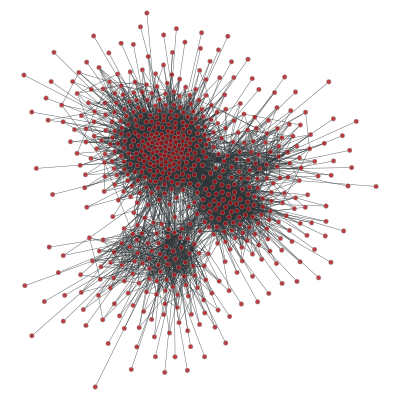

In [4]:
import pandas as pd
users_data = pd.read_csv('../data/btw13/users.txt', header='infer', delimiter='\t', encoding='utf-8', index_col="user_id")
retweet_data = pd.read_csv('../data/btw13/retweet.txt', header='infer', delimiter='\t', encoding='utf-8', index_col="transaction_id")
network = gt.Graph(directed=False)
for i in users_data.index:
    network.add_vertex(i)
network.add_edge_list(retweet_data.values)
network = gt.GraphView(network, vfilt=gt.label_largest_component(network))
network = gt.Graph(network, prune=True)

gt.remove_parallel_edges(network)
gt.remove_self_loops(network)

pos = gt.sfdp_layout(network)
gt.graph_draw(network, output_size=(400, 400), pos=pos);  

<div class="alert alert-success">
    <b>Exercise 1</b> 
    
Find the blocks of the network. Investigate the differences between the degree-corrected SBM and the standard one. 

</div>

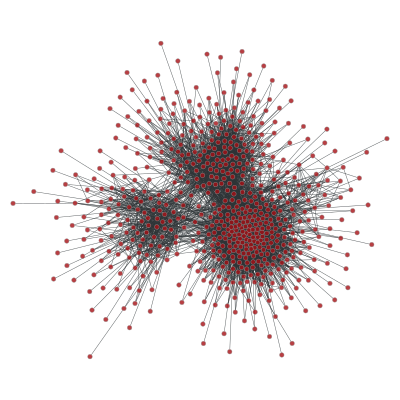

In [5]:
pos = gt.sfdp_layout(network)
gt.graph_draw(network, output_size=(400, 400), pos=pos);  

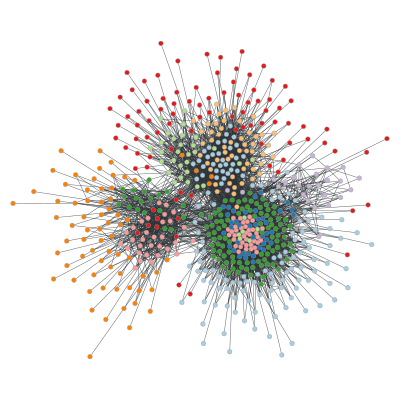

In [6]:
state = gt.minimize_blockmodel_dl(network, deg_corr=False)
b = state.get_blocks()
gt.graph_draw(network, output_size=(400, 400), pos=pos, vertex_fill_color=node_colors(network, b.a));  

Number of blocks:

In [7]:
state.B

17

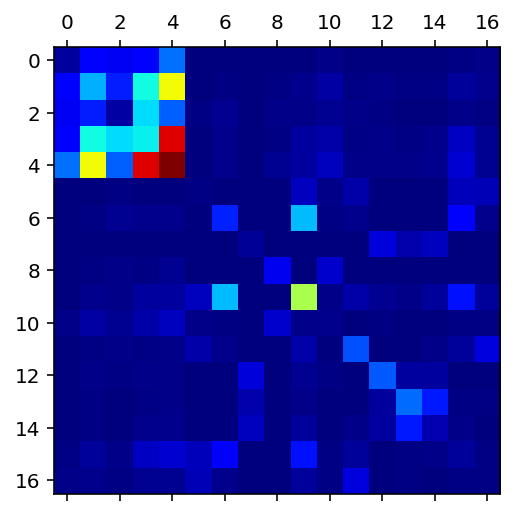

In [8]:
plt.matshow(state.get_matrix().todense(), cmap=plt.cm.jet);

The well-connected nodes can influence the block assignment.

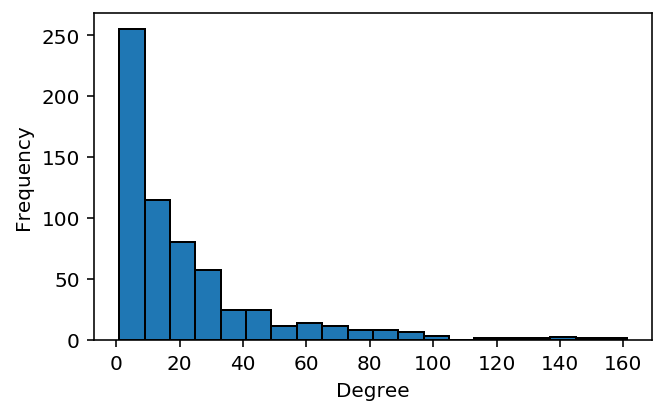

In [9]:
plt.figure(figsize=(5, 3))
plt.hist([i for i in network.degree_property_map('total')], bins=20, edgecolor='k')
plt.xlabel('Degree')
plt.ylabel('Frequency');

The degree-corrected stochastic block model includes the degree sequence in the model.

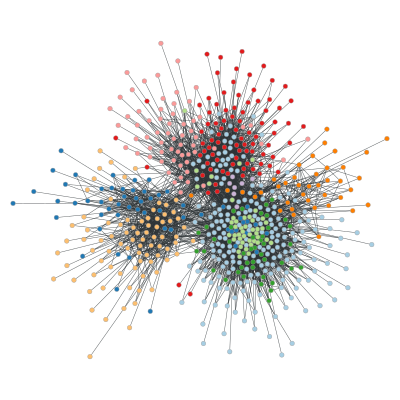

In [10]:
state = gt.minimize_blockmodel_dl(network, deg_corr=True)
b = state.get_blocks()
gt.graph_draw(network, output_size=(400, 400), pos=pos, vertex_fill_color=node_colors(network, b.a));  

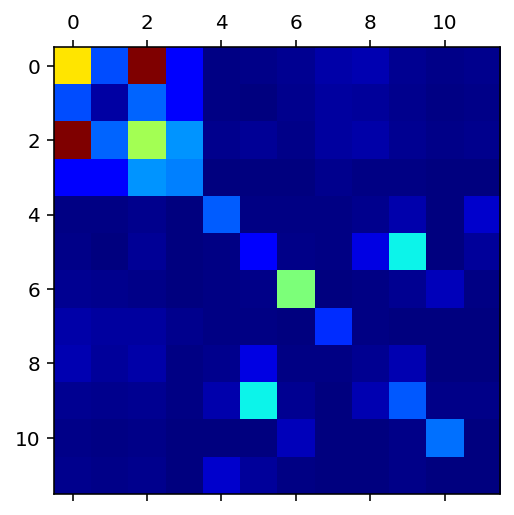

In [11]:
plt.matshow(state.get_matrix().todense(), cmap=plt.cm.jet);

Number of blocks:

In [12]:
state.B

12

<div class="alert alert-success">
    <b>Exercise 2</b> 
    
Generate similar networks to the Twitter network using the fitted SBM. How similar these networks are from the real one? 
</div>

- <code>state.sample_graph()</code>: with the fitted SBM, you can sample a graph from the ensemble.

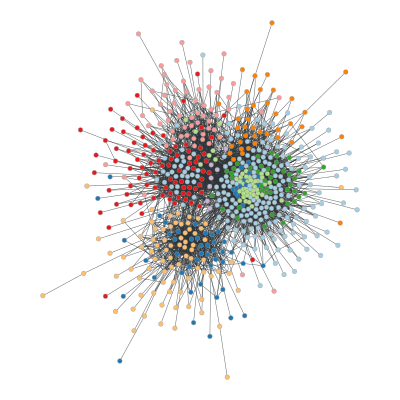

In [13]:
g_ = state.sample_graph()
pos = gt.sfdp_layout(g_)
gt.graph_draw(g_, output_size=(400, 400), pos=pos, vertex_fill_color=node_colors(g_, b.a));  

<div class="alert alert-success">
    <b>Exercise 3</b> 

Compare the description length of the model with and without degree correction. Investigate the difference as the number of blocks $B$ increases. 
</div>

In [14]:
number_of_blocks_list = range(2, 40)
entropies = []
for n_b_i in number_of_blocks_list:
    state = gt.minimize_blockmodel_dl(network, deg_corr=False, B_max=n_b_i, B_min=n_b_i)
    entropies.append(state.entropy(adjacency=True, dl=True, dense=True, multigraph=False, exact=True))

In [15]:
dc_entropies = []
for n_b_i in number_of_blocks_list:
    state = gt.minimize_blockmodel_dl(network, deg_corr=True, B_max=n_b_i, B_min=n_b_i)
    dc_entropies.append(state.entropy(adjacency=True, dl=True, dense=False, multigraph=False, exact=True))

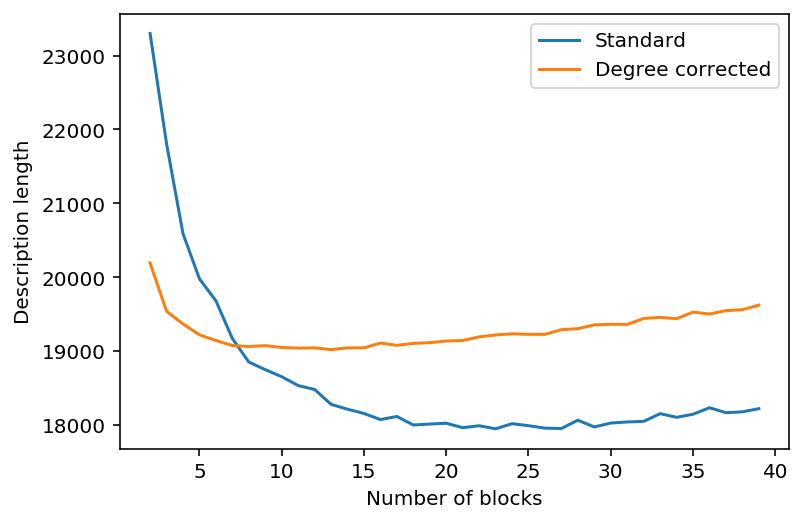

In [16]:
plt.plot(number_of_blocks_list, entropies, label="Standard")
plt.plot(number_of_blocks_list, dc_entropies, label="Degree corrected")
plt.xlabel("Number of blocks")
plt.ylabel("Description length")
plt.legend();

<div class="alert alert-success">
    <b>Exercise 4</b> 

Compare the communities you found using community detection algorithms and the blocks you found here.
</div>

When we analyze using block modeling, it looks like we have a core-perephery in the network in some parts of it.

<div class="alert alert-success">
    <b>Exercise 5</b> 
    
Similar to the Exercise 4 in the Community class, create a graph for each block in the network. For each of them, calculate the average degree, the clustering coefficient, and the average shortest path length. Compare with the values you found in the other class. </div>

In [17]:
state = gt.minimize_blockmodel_dl(network)

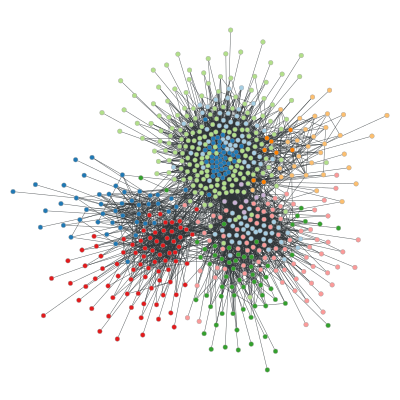

In [18]:
b = state.get_blocks()
gt.graph_draw(network, output_size=(400, 400), vertex_fill_color=node_colors(network, b.a));  

In [19]:
node_degree = [i for i in network.degree_property_map('total')]
node_degree = dict(zip(range(len(node_degree)), node_degree))

In [20]:
degrees_per_block = {}
for node in range(len(node_degree)):
    node_block = b[node]
    if node_block not in degrees_per_block:
        degrees_per_block[node_block] = []
    degrees_per_block[node_block].append(node_degree[node])

In [21]:
for degree_block in degrees_per_block.values():
    print(np.mean(degree_block))

26.48936170212766
80.90697674418605
17.853107344632768
8.387096774193548
10.170731707317072
10.949367088607595
5.875
28.625
56.57142857142857
33.27272727272727
10.152173913043478
31.0


Note that the average degree of some blocks are high. It is because some of them are the cores.